# 训练你的物体检测器

In [ ]:
!pip install gluoncv

In [1]:
import gluoncv as gcv
import mxnet as mx

# 准备训练集

In [2]:
import os

class DetectionDataset(gcv.data.VOCDetection):
    CLASSES = ['short sleeve top', 'trousers', 'long sleeve top', 'short sleeve dress', 'long sleeve outwear', 'sling dress', 'shorts', 'vest', 'vest dress', 'long sleeve dress', 'sling', 'skirt', 'short sleeve outwear']
    def __init__(self, root):
        self._im_shapes = {}
        self._root = os.path.expanduser(root)
        self._transform = None
        self._items = [(self._root, x.strip('.jpg')) for x in os.listdir(self._root) if x.endswith('.jpg')]
        self._anno_path = os.path.join('{}/../annos/', '{}.xml')
        self._image_path = os.path.join('{}', '{}.jpg')
        self.index_map = dict(zip(self.classes, range(self.num_class)))
        self._label_cache = self._preload_labels()
        
    def __str__(self):
        detail = self._root
        return self.__class__.__name__ + '(' + detail + ')'
    
    @property
    def classes(self):
        return self.CLASSES
    
    @property
    def num_class(self):
        return len(self.classes)
        
# train_dataset = DetectionDataset('data/tiny_train/image/')
train_dataset = DetectionDataset('data/train/image/')
print('class_names:', train_dataset.classes)
print('num_images:', len(train_dataset))

class_names: ['short sleeve top', 'trousers', 'long sleeve top', 'short sleeve dress', 'long sleeve outwear', 'sling dress', 'shorts', 'vest', 'vest dress', 'long sleeve dress', 'sling', 'skirt', 'short sleeve outwear']
num_images: 191961


# 可视化数据

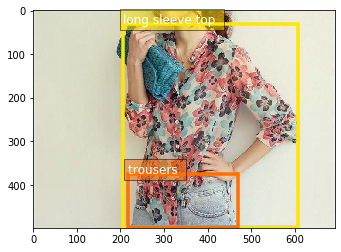

In [3]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

sample = train_dataset[0]
train_image = sample[0]
train_label = sample[1]

ax = viz.plot_bbox(
    train_image.asnumpy(),
    train_label[:, :4],
    labels=train_label[:, 4:5],
    class_names=train_dataset.classes)
plt.show()

# for i in range(len(train_dataset)):
#     sample = train_dataset[i]
#     train_image = sample[0]
#     train_label = sample[1]

#     ax = viz.plot_bbox(
#         train_image.asnumpy(),
#         train_label[:, :4],
#         labels=train_label[:, 4:5],
#         class_names=train_dataset.classes)
#     plt.show()

# 定义训练过程

In [4]:
import time
from datetime import datetime
from mxnet import autograd
from gluoncv.data.batchify import Tuple, Stack, Pad

def train_model(train_dataset, epochs=50):
    ctx = mx.gpu(0)
#     ctx = mx.cpu(0)
    net = gcv.model_zoo.get_model('ssd_512_resnet50_v1_custom', classes=train_dataset.classes, transfer='coco')
#     net.load_parameters('object_detector_epoch200_10_22_2019_20_28_41.params')  # TODO continue training
    net.collect_params().reset_ctx(ctx)
    width, height = 512, 512  # suppose we use 512 as base training size
    train_transform = gcv.data.transforms.presets.ssd.SSDDefaultTrainTransform(width, height)
    gcv.utils.random.seed(233)
    
#     batch_size = 4
    batch_size = 16  # 32 for p3.2xlarge, 16 for p2.2xlarge
    # you can make it larger(if your CPU has more cores) to accelerate data loading
    num_workers = 4

    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width), ctx))
    anchors = anchors.as_in_context(mx.cpu())
    train_transform = gcv.data.transforms.presets.ssd.SSDDefaultTrainTransform(width, height, anchors)
    batchify_fn = Tuple(Stack(), Stack(), Stack())
    train_loader = mx.gluon.data.DataLoader(
        train_dataset.transform(train_transform),
        batch_size,
        shuffle=True,
        batchify_fn=batchify_fn,
        last_batch='rollover',
        num_workers=num_workers)
    
    mbox_loss = gcv.loss.SSDMultiBoxLoss()
    ce_metric = mx.metric.Loss('CrossEntropy')
    smoothl1_metric = mx.metric.Loss('SmoothL1')
    for k, v in net.collect_params().items():
        if 'convpredictor' not in k:
            # freeze upper layers
            v.grad_req = 'null'
    trainer = mx.gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})
    
    net.hybridize(static_alloc=True, static_shape=True)
    
    for epoch in range(epochs):
        tic = time.time()
        btic = time.time()
        
        for i, batch in enumerate(train_loader):
            data = mx.gluon.utils.split_and_load(batch[0], ctx_list=[ctx], batch_axis=0)
            cls_targets = mx.gluon.utils.split_and_load(batch[1], ctx_list=[ctx], batch_axis=0)
            box_targets = mx.gluon.utils.split_and_load(batch[2], ctx_list=[ctx], batch_axis=0)
            
            with autograd.record():
                cls_preds = []
                box_preds = []
                for x in data:
                    cls_pred, box_pred, _ = net(x)
                    cls_preds.append(cls_pred)
                    box_preds.append(box_pred)
                sum_loss, cls_loss, box_loss = mbox_loss(
                    cls_preds, box_preds, cls_targets, box_targets)
                autograd.backward(sum_loss)
            # since we have already normalized the loss, we don't want to normalize
            # by batch-size anymore
            trainer.step(1)
            ce_metric.update(0, [l * batch_size for l in cls_loss])
            smoothl1_metric.update(0, [l * batch_size for l in box_loss])
            name1, loss1 = ce_metric.get()
            name2, loss2 = smoothl1_metric.get()
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
            btic = time.time()
    return net

# 开始训练

In [ ]:
epochs = 10
net = train_model(train_dataset, epochs=epochs)
save_file = 'object_detector_epoch{}_{}.params'.format(epochs, datetime.now().strftime("%m_%d_%Y_%H_%M_%S"))
net.save_parameters(save_file)
print('Saved model to disk: ' + save_file)

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1454: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


[Epoch 0][Batch 0], Speed: 1.634 samples/sec, CrossEntropy=15.881, SmoothL1=1.709
[Epoch 0][Batch 1], Speed: 62.242 samples/sec, CrossEntropy=15.282, SmoothL1=1.927
[Epoch 0][Batch 2], Speed: 62.010 samples/sec, CrossEntropy=14.752, SmoothL1=1.898
[Epoch 0][Batch 3], Speed: 58.873 samples/sec, CrossEntropy=14.357, SmoothL1=1.874
[Epoch 0][Batch 4], Speed: 60.862 samples/sec, CrossEntropy=13.937, SmoothL1=1.918
[Epoch 0][Batch 5], Speed: 60.492 samples/sec, CrossEntropy=13.643, SmoothL1=1.935
[Epoch 0][Batch 6], Speed: 60.593 samples/sec, CrossEntropy=13.369, SmoothL1=1.935
[Epoch 0][Batch 7], Speed: 61.459 samples/sec, CrossEntropy=13.108, SmoothL1=1.949
[Epoch 0][Batch 8], Speed: 52.089 samples/sec, CrossEntropy=12.887, SmoothL1=1.956
[Epoch 0][Batch 9], Speed: 14.738 samples/sec, CrossEntropy=12.668, SmoothL1=1.956
[Epoch 0][Batch 10], Speed: 9.559 samples/sec, CrossEntropy=12.480, SmoothL1=1.947
[Epoch 0][Batch 11], Speed: 54.975 samples/sec, CrossEntropy=12.294, SmoothL1=1.932
[Epo